<a href="https://colab.research.google.com/github/john-d-noble/Auto-Lending-Startup-Case-Study-Data-Science-Leadership/blob/master/Model%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Running Monte Carlo Simulation (10,000 iterations)...
Simulation Complete.

--- Monte Carlo Simulation: Summary of Outcome ---
Average (Mean) IRR:      82.18%
Median (50th Pct) IRR:   83.08%
--------------------------------------------------
Probability of meeting 20% target: 99.66%
Probability of losing money (IRR < 0%): 0.05%
--------------------------------------------------
Worst 5% of outcomes have an IRR below: 49.89%
Best 5% of outcomes have an IRR above: 111.92%


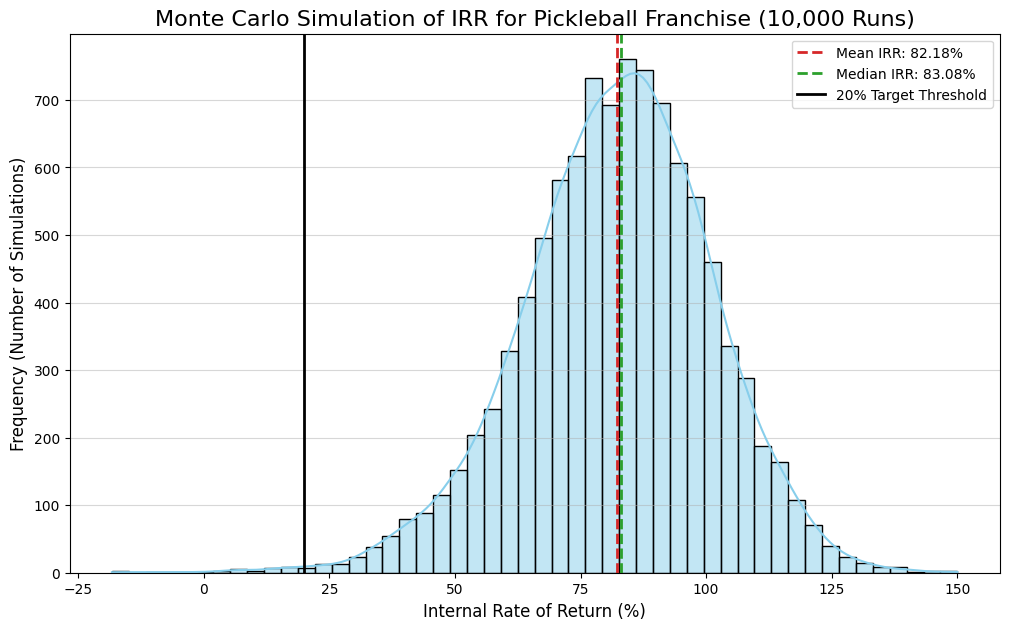

In [1]:
# === SECTION 1: IMPORT LIBRARIES ===
# These are pre-built Python packages that provide tools for our analysis.

import numpy as np  # The fundamental package for numerical computation. We use it for mathematical operations and generating random numbers for the simulation.
from scipy.optimize import brentq  # A specific function from the SciPy library used for finding the root of an equation, which is perfect for calculating IRR.
import pandas as pd  # A powerful data analysis library. We use it to easily calculate statistics (like mean, median) from our simulation results.
import matplotlib.pyplot as plt  # The primary library for creating charts and graphs (visualizations).
import seaborn as sns  # A library built on top of Matplotlib that provides more attractive and informative statistical graphics.


# === SECTION 2: CONFIGURATION ===
# This dictionary holds all the core assumptions for our financial model.
# By keeping them here, we can easily change an assumption without digging through the code.

config = {
    # --- Investment & Asset Assumptions ---
    'initial_investment': 867000,    # The total upfront cost to build and open the franchise.
    'asset_life_years': 10,         # The number of years over which the initial investment will be depreciated for tax purposes.

    # --- Revenue Driver Assumptions (for Year 1) ---
    'num_courts': 12,                       # The number of pickleball courts in the facility.
    'num_members': 1000,                    # The target number of paying members in the first year.
    'monthly_membership_fee': 100,          # The monthly fee charged per member.
    'court_rental_rate': 20,                # The hourly rental rate for a single court for non-members.
    'court_hours_per_day': 6,               # The average number of hours per day each court is rented out.
    'days_open_per_year': 360,              # The number of days the facility is operational per year.
    'court_utilization': 0.50,              # The percentage of available rental hours that are actually booked (50%).
    'pro_shop_revenue_as_share': 0.05,      # Pro shop sales are assumed to be 5% of total revenue.
    'f_and_b_revenue_as_share': 0.05,       # Food & Beverage sales are assumed to be 5% of total revenue.
    'tournament_revenue_as_share': 0.05,    # Tournament fees are assumed to be 5% of total revenue.

    # --- Growth & Cost Assumptions ---
    'revenue_growth_rate': 0.10,            # The assumed annual percentage growth in total revenue after Year 1 (10%).
    'operating_costs_per_month': 80000,     # The fixed monthly costs to run the facility (rent, staff, utilities).
    'operating_costs_growth_rate': 0.05,    # The assumed annual increase in operating costs due to inflation (5%).
    'royalty_rate': 0.08,                   # The percentage of total revenue paid to the franchisor (Pickleball Kingdom) as a royalty fee (8%).
    'marketing_fee_rate': 0.02,             # The percentage of total revenue paid to the franchisor for national marketing (2%).

    # --- Financial & Valuation Assumptions ---
    'years': 5,                             # The explicit forecast period for our financial model (5 years).
    'tax_rate': 0.25,                       # The combined federal and state corporate income tax rate (25%).
    'terminal_growth_rate': 0.02            # The assumed perpetual growth rate of the business's cash flow after Year 5, used to calculate its ongoing value.
}


# === SECTION 3: CORE FINANCIAL CALCULATION ENGINE ===
# This function takes a configuration dictionary and calculates the project's cash flows.

def calculate_financials_robust(cfg):
    """
    Calculates the full series of free cash flows based on a given configuration.
    """
    # --- Depreciation ---
    # Calculate the annual depreciation expense using the straight-line method.
    depreciation_per_year = cfg['initial_investment'] / cfg['asset_life_years']

    # --- Year 1 Revenue Calculation (Bottom-Up) ---
    # Calculate revenue from primary sources.
    membership_revenue = cfg['num_members'] * cfg['monthly_membership_fee'] * 12
    court_rental_revenue = cfg['num_courts'] * cfg['court_rental_rate'] * cfg['court_hours_per_day'] * cfg['days_open_per_year'] * cfg['court_utilization']
    base_operational_revenue = membership_revenue + court_rental_revenue

    # Calculate total revenue by including ancillary streams (pro shop, F&B, etc.).
    # This math finds the 'total revenue' pie when we know the size of the main slices (base_operational_revenue)
    # and the other slices are defined as a percentage of the whole pie.
    total_revenue_denominator = (1 - cfg['pro_shop_revenue_as_share'] - cfg['f_and_b_revenue_as_share'] - cfg['tournament_revenue_as_share'])
    if total_revenue_denominator == 0: total_revenue_denominator = 1 # Avoid a division-by-zero error.
    year1_revenue = base_operational_revenue / total_revenue_denominator

    # --- Year 1 Operating Costs ---
    year1_operating_costs = cfg['operating_costs_per_month'] * 12

    # --- Project Financials over the Forecast Period ---
    # Initialize lists to hold the annual values.
    revenues = [year1_revenue]
    operating_costs = [year1_operating_costs]

    # Loop from the second year to the end of the forecast period.
    for y in range(1, cfg['years']):
        # Apply the growth rates to project future revenues and costs.
        revenues.append(revenues[-1] * (1 + cfg['revenue_growth_rate']))
        operating_costs.append(operating_costs[-1] * (1 + cfg['operating_costs_growth_rate']))

    # --- Calculate Profits and Cash Flows ---
    # Calculate annual franchise fees based on total revenue.
    royalties = [rev * cfg['royalty_rate'] for rev in revenues]
    marketing_fees = [rev * cfg['marketing_fee_rate'] for rev in revenues]

    # EBITDA: A measure of profitability before non-cash expenses and taxes.
    ebitda = [rev - op_cost - roy - mar for rev, op_cost, roy, mar in zip(revenues, operating_costs, royalties, marketing_fees)]

    # EBT (Earnings Before Tax): Subtract depreciation (a tax-deductible expense).
    ebt = [e - depreciation_per_year for e in ebitda]

    # Taxes: Calculate the tax owed based on the tax rate. No tax if there's a loss.
    taxes = [e * cfg['tax_rate'] if e > 0 else 0 for e in ebt]

    # Net Income: The "bottom line" profit after all expenses, including taxes.
    net_income = [e - t for e, t in zip(ebt, taxes)]

    # Free Cash Flow (FCF): The actual cash generated. We add back depreciation because it's a non-cash expense.
    free_cash_flows_proj = [ni + depreciation_per_year for ni in net_income]

    # --- Terminal Value Calculation ---
    # This estimates the value of the business at the end of the 5-year forecast period, assuming it continues to operate.
    discount_rate = 0.15 # We assume a 15% discount rate (or required rate of return) for a risky venture like a new franchise.
    if discount_rate <= cfg['terminal_growth_rate']: discount_rate = cfg['terminal_growth_rate'] + 0.01 # A technical check to ensure the formula works.

    # Use the Gordon Growth Model to calculate terminal value.
    terminal_value = (free_cash_flows_proj[-1] * (1 + cfg['terminal_growth_rate'])) / (discount_rate - cfg['terminal_growth_rate'])

    # Add this large, one-time value to the cash flow of the final year.
    free_cash_flows_proj[-1] += terminal_value

    # --- Final Cash Flow Series ---
    # Return a list starting with the initial investment (a negative cash flow) followed by the projected annual free cash flows.
    return [-cfg['initial_investment']] + free_cash_flows_proj


# === SECTION 4: IRR CALCULATION FUNCTION ===
# A dedicated function to compute the Internal Rate of Return.

def calculate_irr(cash_flows):
    """
    Calculates the IRR for a given series of cash flows.
    IRR is the discount rate that makes the Net Present Value (NPV) of the cash flows equal to zero.
    """
    try:
        # The brentq function numerically finds the 'rate' that solves our NPV equation.
        # We give it a reasonable range to search within (-99% to 500%).
        return brentq(lambda rate: sum(cf / (1 + rate)**t for t, cf in enumerate(cash_flows)), -0.99, 5)
    except (ValueError, RuntimeError):
        # If the algorithm can't find a solution (e.g., all cash flows are negative), return -1.0 to indicate an error.
        return -1.0


# === SECTION 5: MONTE CARLO SIMULATION FUNCTION ===
# This function runs the financial model thousands of times to simulate a range of possible futures.

def run_monte_carlo_simulation(base_config, num_simulations=10000):
    """
    Runs a Monte Carlo simulation using the robust financial model.
    """
    # Create an empty list to store the IRR result from each simulation run.
    irr_results = []

    # Loop for the specified number of simulations (e.g., 10,000 times).
    for i in range(num_simulations):
        # Create a fresh copy of the configuration for this specific run.
        sim_config = base_config.copy()

        # --- Randomize Key Assumptions ---
        # For each uncertain variable, instead of using the fixed value, we draw a random number from a probability distribution.

        # Initial Investment: Uses a triangular distribution (min, most likely, max). Good for modeling costs with potential overruns.
        sim_config['initial_investment'] = np.random.triangular(left=867000, mode=867000, right=1100000)

        # Number of Members: Uses a normal distribution (bell curve) centered around the base case, with a standard deviation.
        sim_config['num_members'] = np.random.normal(loc=base_config['num_members'], scale=150) # 'scale' is standard deviation

        # Court Utilization: Also uses a normal distribution.
        sim_config['court_utilization'] = np.random.normal(loc=base_config['court_utilization'], scale=0.075)

        # Revenue Growth Rate: Another normal distribution to model uncertainty about future growth.
        sim_config['revenue_growth_rate'] = np.random.normal(loc=base_config['revenue_growth_rate'], scale=0.03)

        # --- Run Model and Store Result ---
        # Run the financial model with these newly randomized inputs.
        cash_flows = calculate_financials_robust(sim_config)

        # Calculate the IRR for this specific scenario.
        irr = calculate_irr(cash_flows)

        # Add the resulting IRR to our list, but only if it's a valid number.
        if irr != -1.0:
            irr_results.append(irr)

    # After all simulations are complete, return the list of all possible IRR outcomes.
    return irr_results


# === SECTION 6: MAIN EXECUTION ===
# This is where the script starts running.

# Let the user know the simulation is starting.
print("Running Monte Carlo Simulation (10,000 iterations)...")

# Call the simulation function to get the 10,000 IRR outcomes.
irr_outcomes = run_monte_carlo_simulation(config, num_simulations=10000)

# Confirm completion.
print("Simulation Complete.\n")


# === SECTION 7: ANALYSIS AND SUMMARY OF RESULTS ===
# This section takes the raw simulation results and turns them into meaningful insights.

# Convert the list of IRRs into a pandas Series, which has useful built-in functions for statistics.
irr_series = pd.Series(irr_outcomes)

# --- Calculate Key Performance Indicators (KPIs) ---
mean_irr = irr_series.mean()                                  # The average IRR of all simulations.
median_irr = irr_series.median()                              # The "middle" IRR outcome (50% of outcomes are higher, 50% are lower).
pct_chance_over_20 = (irr_series >= 0.20).mean() * 100       # The percentage of simulations where the IRR met or exceeded the 20% target.
pct_chance_loss = (irr_series < 0).mean() * 100              # The percentage of simulations where the IRR was negative (a financial loss).
percentile_5 = irr_series.quantile(0.05)                      # The IRR value that represents the worst 5% of outcomes.
percentile_95 = irr_series.quantile(0.95)                     # The IRR value that represents the best 5% of outcomes.

# --- Print the Summary to the Console ---
print("--- Monte Carlo Simulation: Summary of Outcome ---")
print(f"Average (Mean) IRR:      {mean_irr*100:.2f}%")
print(f"Median (50th Pct) IRR:   {median_irr*100:.2f}%")
print("-" * 50)
print(f"Probability of meeting 20% target: {pct_chance_over_20:.2f}%")
print(f"Probability of losing money (IRR < 0%): {pct_chance_loss:.2f}%")
print("-" * 50)
print(f"Worst 5% of outcomes have an IRR below: {percentile_5*100:.2f}%")
print(f"Best 5% of outcomes have an IRR above: {percentile_95*100:.2f}%")


# === SECTION 8: VISUALIZATION ===
# This section creates a chart to visually represent the simulation results.

# Set up the plot size for better readability.
plt.figure(figsize=(12, 7))

# Create a histogram using seaborn, which shows the frequency of different IRR outcomes. The 'kde=True' adds a smooth line showing the shape of the distribution.
sns.histplot(irr_series * 100, bins=50, kde=True, color='skyblue')

# Add vertical lines to the plot to mark key statistical points.
plt.axvline(x=mean_irr*100, color='#d62728', linestyle='--', linewidth=2, label=f'Mean IRR: {mean_irr*100:.2f}%')
plt.axvline(x=median_irr*100, color='#2ca02c', linestyle='--', linewidth=2, label=f'Median IRR: {median_irr*100:.2f}%')
plt.axvline(x=20, color='black', linestyle='-', linewidth=2, label='20% Target Threshold')

# Add titles and labels to make the chart easy to understand.
plt.title('Monte Carlo Simulation of IRR for Pickleball Franchise (10,000 Runs)', fontsize=16)
plt.xlabel('Internal Rate of Return (%)', fontsize=12)
plt.ylabel('Frequency (Number of Simulations)', fontsize=12)
plt.legend()  # Display the labels for the vertical lines.
plt.grid(axis='y', alpha=0.5) # Add a light grid to the y-axis for easier reading.

# Display the final plot.
plt.show()